In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l2


In [ ]:
# Завантаження та підготовка даних
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=169)



train_X = np.stack((x_train,) * 3, axis=-1)
val_X = np.stack((x_val,) * 3, axis=-1)
test_X = np.stack((x_test,) * 3, axis=-1)

train_X = tf.image.resize(train_X, (48, 48))
val_X = tf.image.resize(val_X, (48, 48))
test_X = tf.image.resize(test_X, (48, 48))

y_train = keras.utils.to_categorical(y_train, 10)
y_val = keras.utils.to_categorical(y_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)


4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Створення моделі VGG16 без верхніх повністю зв'язаних шарів
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

base_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [ ]:
#Препроцесинг
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(train_X)

In [ ]:
#Створення мделі
model = Sequential([
   base_model,
   Flatten(),
   Dense(1024, activation="relu", kernel_regularizer=l2(0.01)),
   Dense(512, activation="relu", kernel_regularizer=l2(0.01)),
   Dense(10, activation="softmax"),
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 10)                5130      
                                                                 
Total params: 15769930 (60.16 MB)
Trainable params: 8134666 (31.03 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [ ]:
 #Навчання моделі
history = model.fit(
    datagen.flow(train_X, y_train, batch_size=256),
    epochs=30,
    validation_data=(val_X, y_val),
    steps_per_epoch=len(train_X) // 256)

Epoch 1/30
187/187 [==============================] - 52s 262ms/step - loss: 2.9098 - accuracy: 0.8800 - val_loss: 0.5988 - val_accuracy: 0.8911
Epoch 2/30
187/187 [==============================] - 48s 258ms/step - loss: 0.4437 - accuracy: 0.8882 - val_loss: 0.3417 - val_accuracy: 0.9003
Epoch 3/30
187/187 [==============================] - 48s 259ms/step - loss: 0.3554 - accuracy: 0.8886 - val_loss: 0.3417 - val_accuracy: 0.8928
Epoch 4/30
187/187 [==============================] - 48s 258ms/step - loss: 0.3436 - accuracy: 0.8885 - val_loss: 0.3198 - val_accuracy: 0.8987
Epoch 5/30
187/187 [==============================] - 48s 255ms/step - loss: 0.3342 - accuracy: 0.8886 - val_loss: 0.3179 - val_accuracy: 0.8964
Epoch 6/30
187/187 [==============================] - 49s 262ms/step - loss: 0.3218 - accuracy: 0.8925 - val_loss: 0.3066 - val_accuracy: 0.9005
Epoch 7/30
187/187 [==============================] - 48s 257ms/step - loss: 0.3181 - accuracy: 0.8921 - val_loss: 0.2830 - val_ac

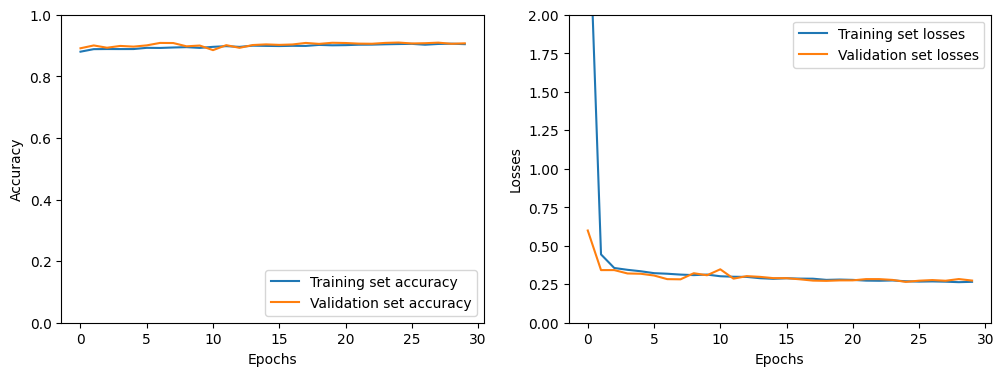

In [ ]:
# Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training set accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation set accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training set losses')
plt.plot(history.history['val_loss'], label = 'Validation set losses')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.ylim([0, 2])
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Evaluate the model on test data
y_pred = model.predict(test_X)
test_loss, test_acc = model.evaluate(test_X, y_test, verbose=1)
print(f'\nTest set accuracy: {test_acc * 100:.2f}%')

313/313 [==============================] - 4s 12ms/step - loss: 0.2969 - accuracy: 0.9013

Test set accuracy: 90.13%


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

report = classification_report(np.argmax(y_test, axis=1), y_pred.argmax(axis=1), target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.88      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.82      0.89      0.85      1000
       Dress       0.91      0.84      0.87      1000
        Coat       0.87      0.81      0.84      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.73      0.72      0.72      1000
     Sneaker       0.94      0.97      0.96      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



##Точність (Precision) для кожного класу:

Найвища точність спостерігається для класів "Trouser" (99%), "Sandal" (99%), "Bag" (98%), "Ankle boot" (98%), "Sneaker" (94%) і "Dress" (91%),  що свідчить про добре розпізнавання цих класів моделлю.


Клас "Coat" (88%) також має хорошу точність, але меншу, ніж вищеназвані класи.


Класи "T-shirt/top" (82%), "Pullover" (82%), і "Shirt" (73%) мають меншу точність, і модель робить більше помилок при розпізнаванні цих класів.


##Повнота (Recall) для кожного класу:

Класи "Trouser" (98%), "Sandal" (97%), "Sneaker" (97%), "Bag" (99%), і "Ankle boot" (96%) мають високу повноту, що означає, що модель добре розпізнає екземпляри цих класів.


Класи "Dress" (84%), "T-shirt/top" (88%), "Pullover" (89%), і "Coat" (81%) також мають досить високу повноту, але меншу, ніж вищеназвані класи.


Клас "Shirt" (72%) має найменшу повноту серед усіх класів, що означає, що модель помиляється при визначенні більшості зразків цього класу.


##F1-рівень (F1-Score):

Загальний F1-рівень для моделі на тестовому наборі становить 0,91, що свідчить про добрі результати класифікації.


Класи з високими F1-рівнями включають "Trouser" (99%), "Sandal" (98%), "Bag" (99%), "Sneaker" (96%), і "Ankle boot" (97%).


Класи "Dress" (87%) і "Coat" (84%), "T-shirt/top" (85%), "Pullover" (85%), також мають досить високий F1-рівень, але менший, ніж у попередніх.


Клас "Shirt" (72%) має менший F1-рівень, що свідчить про те, що модель не так ефективно розпізнає цей клас.


#Загальний висновок:

Загальна точність моделі на тестовому наборі становить 90%, що є досить хорошим результатом.

Узагальнюючи, модель досягла досить хороших результатів на датасеті Fashion MNIST, з загальною точністю близько 90%. Проте загальна точність даної моделі трохи менша за попередню.

Деякі класи дана модель розпізнає краще за попередню, деякі гірше, але вцілому точність знаходиться приблизно на однаковому рівні.

Думаю точність можна покращити за рахунок підбору кількості шарів, їх типів та кількості нейронів.